## Mechanisms involved in xyloglucan catabolism by the cellulosome-producing bacterium Ruminiclostridium cellulolyticum ([Ravachol et al. 2016](https://www.nature.com/articles/srep22770#MOESM79))

In [1]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

In [2]:
import cobra
from cobra.io import load_model

import pandas as pd
import copy
import numpy as np

import molmass
import reframed

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from optimparallel import minimize_parallel
from scipy.optimize import differential_evolution

import matplotlib.colors as mcolors

import sys
sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2

from dfba_param_opt_cobra import read_model,add_dynamic_bounds, optimize_parameters_inner_problem_simplified
from dfba_param_opt_cobra import optimize_parameters_inner_problem_oligo

from differential_evolution_process_results import process_results

### Differential evolution

**Input parameters for experiment**

In [32]:
OD = pd.read_csv("../input/Ravachol2016_batch_data/OD_xyloglucan.csv")
OD[" y"] = OD[" y"]*0.5

model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})

C_dict =OrderedDict({
"Growth":OD.iloc[0,1],
"EX_QQQG_e": 0,
"EX_xylogluc_e": 3.5*1000/(molarmass/xylog_glc_eq_dict["EX_QQQG_e"])
})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


#### Function to be able to backtrack previous solutions

In [33]:
from concurrent.futures import ProcessPoolExecutor

# Initialize any shared variables if needed
pop_min = []
energies_min = []

def maplike_fun(func, x, *args, max_workers=4):
    # Store the current population
    print(x)
    pop_min.append(np.copy(x))

    # Evaluate the objective function for each individual in parallel
    e = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit each individual to the executor, running them in parallel
        futures = [executor.submit(func, x_i, *args) for x_i in x]
        
        # Collect the results as they complete
        for future in futures:
            e.append(future.result())
    
    # Store the energies (objective function values)
    energies_min.append(e)
    
    # Return the objective values, ensuring it matches the length of x
    return e

### Polishing solutions

In [82]:
best_evo_min_sorted = pd.read_csv("../output/differential_evolution_results_xyloglucan.csv",index_col=0)
best_evo_min_sorted.reset_index(drop=True,inplace=True)

#### Plotting results

In [81]:
df_results = pd.read_csv("../output/polished_results_diff_ev.tsv",sep="\t",header=[0,1],index_col=0)
df_results

origin diff_ev                                                               \
data   message                                         parameters   penalty   
0          NaN  [0.3798709  2.23482836 9.55233823 4.85941385 9...  2.591862   
1          NaN  [0.50195709 3.68644078 9.69460177 3.31764892 3...  3.162242   
2          NaN  [0.35036657 2.19795486 9.41110101 2.65089561 6...  3.552179   
3          NaN  [0.32158045 0.73902224 4.1596167  4.33875322 4...  4.270632   
4          NaN  [0.45470864 2.50010501 7.30293181 3.26166072 4...  4.822052   
5          NaN  [0.35460383 1.4825284  6.41284601 2.84348342 6...  5.803374   
6          NaN  [0.91262437 7.40241764 7.43758067 0.85813119 3...  6.431278   
7          NaN  [0.53424852 2.23482836 5.92194077 5.4954347  2...  6.707871   
8          NaN  [0.73869453 4.29931486 8.11391257 8.47783781 8...  7.099287   
9          NaN  [0.58903836 3.2747056  6.6296893  1.93410799 0...  7.696700   

origin                                         polished  \
data                                            message   
0       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
1       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
2       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
3       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
4       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
5       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
6       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
7       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
8                        ABNORMAL_TERMINATION_IN_LNSRCH   
9       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

origin                                                               
data                                           parameters   penalty  
0       [0.38000556 2.23436476 9.55243545 4.85959828 9...  2.591672  
1       [0.50511797 3.66367911 9.63370877 3.36005906 3...  3.016322  
2       [0.35598368 2.16894594 9.41966081 2.75441634 6...  1.895582  
3       [0.18752184 0.1888305  4.29008149 4.30384578 4...  1.490756  
4       [0.45344037 2.49325058 7.30129569 3.26142147 4...  4.811018  
5       [0.19789834 0.42073016 6.87631117 2.36726946 5...  1.290342  
6       [0.90691786 7.40649122 7.4266249  0.85629226 3...  6.221623  
7       [0.53316986 2.24810073 5.91237237 5.49894156 2...  6.443526  
8       [0.73536206 4.29567899 8.12083797 8.47764617 8...  7.050773  
9       [0.58507989 3.30746961 6.59890907 1.95492679 0...  6.052188

In [83]:
polished_df = df_results.xs("polished",axis=1)[["parameters","penalty"]].sort_values("penalty",ascending=False).copy()

In [55]:
best_results_dict = OrderedDict()

for i,row in polished_df.iterrows():
    print(i)
    
    s = row["parameters"]
    s = s.strip("[]")
    combination = list(map(float,s.split()))
    model = read_model(media)
    
    
    sol,penalty = optimize_parameters_inner_problem_simplified(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,xylog_glc_eq_dict=xylog_glc_eq_dict,OD=OD,alternative_solution=True)
    
    C_dict_results = dict(zip(C_dict.keys(),sol.y))
    
    best_results_dict[round(penalty,3)]=(sol.t,C_dict_results)
    

8
[0.73536206, 4.29567899, 8.12083797, 8.47764617, 8.14759341]
penalty: 7.050719209924314
7
[0.53316986, 2.24810073, 5.91237237, 5.49894156, 2.50289926]
penalty: 6.443539107393946
6
[0.90691786, 7.40649122, 7.4266249, 0.85629226, 3.51130595]
penalty: 6.220230612881935
9
[0.58507989, 3.30746961, 6.59890907, 1.95492679, 0.8575517]
penalty: 6.052171568412058
4
[0.45344037, 2.49325058, 7.30129569, 3.26142147, 4.14073324]
penalty: 4.811017982405414
1
[0.50511797, 3.66367911, 9.63370877, 3.36005906, 3.70195741]
penalty: 3.0162795071869857
0
[0.38000556, 2.23436476, 9.55243545, 4.85959828, 9.18330057]
penalty: 2.591671977260862
2
[0.35598368, 2.16894594, 9.41966081, 2.75441634, 6.90007295]
penalty: 1.8948562823115551
3
[0.18752184, 0.1888305, 4.29008149, 4.30384578, 4.64179345]
penalty: 1.490756289167049
5
[0.19789834, 0.42073016, 6.87631117, 2.36726946, 5.82621848]
penalty: 1.2903433639383657


In [64]:
# Generate some example values between 1 and 120, with many values clustered near 10
values = list(best_results_dict.keys())

# Use LogNorm to normalize values logarithmically
log_norm = mcolors.LogNorm(vmin=1, vmax=20)

# Choose a colormap, e.g., viridis
cmap = plt.cm.gist_rainbow_r
cmap(log_norm(values[0]))

(0.27556968733439313, 1.0, 0.0, 1.0)

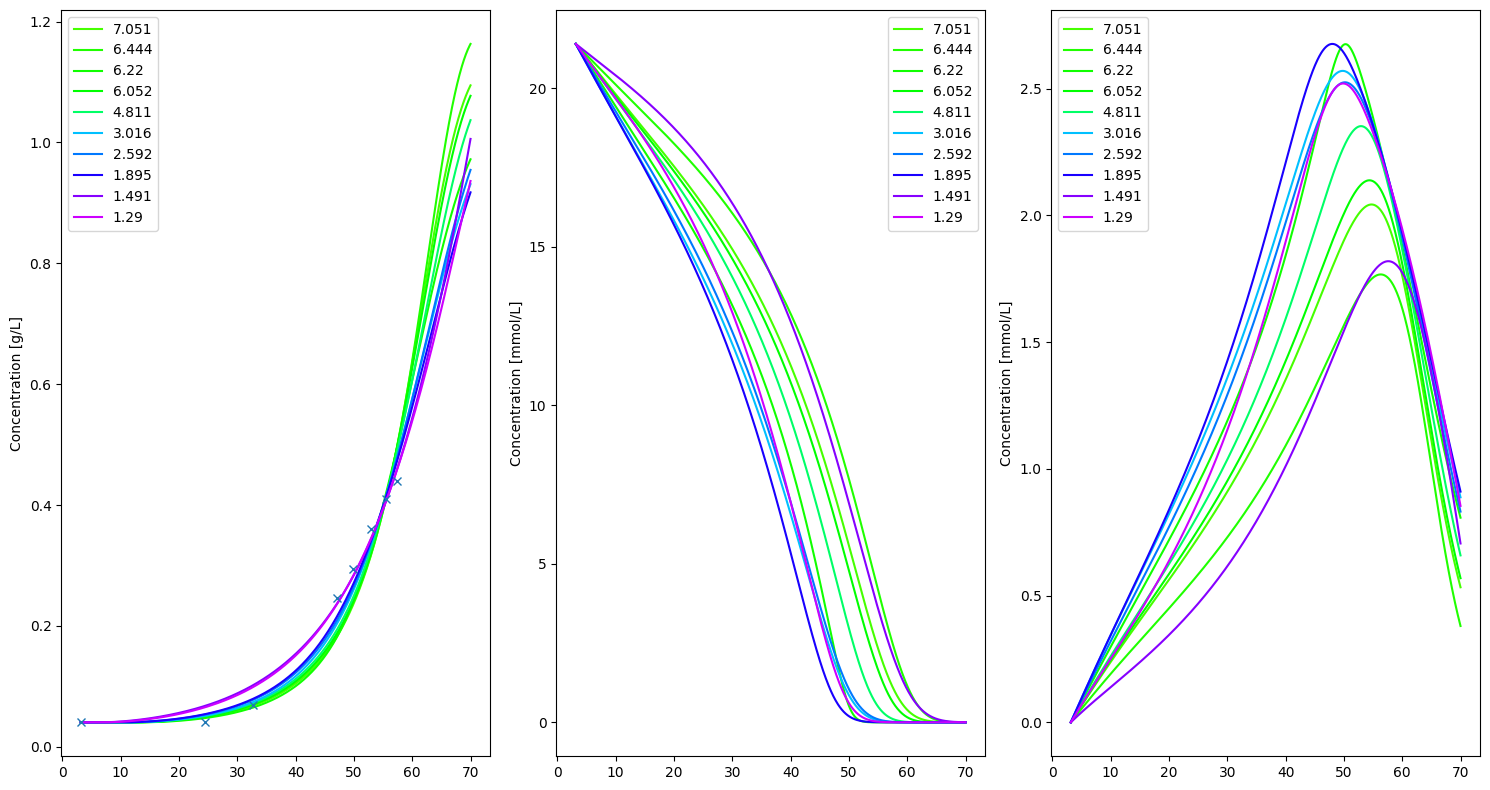

In [65]:
fig,ax = plt.subplots(1,3,figsize=(15,8))


for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[0].plot(t, C_dict_results["Growth"],label =str(key),color=cmap(log_norm(key)))

ax[0].legend()
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD.x,OD[" y"],'x',color="tab:blue")

for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[1].plot(t, C_dict_results["EX_xylogluc_e"], label =str(key),color=cmap(log_norm(key)))
ax[1].legend()
ax[1].set_ylabel('Concentration [mmol/L]')

colors = ['r','g','y','b','pink']
for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[2].plot(t, C_dict_results["EX_QQQG_e"], label =str(key),color=cmap(log_norm(key)))
ax[2].legend()
ax[2].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()

### Oligosaccharides

In [84]:
OD_oligo = pd.read_csv("../input/Ravachol2016_batch_data/OD_oligosaccharide.csv")

OD_oligo[" y"] = OD_oligo[" y"]*0.5

In [69]:
model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})


C_dict =OrderedDict({
"Growth":OD_oligo.iloc[0,1],
"EX_QQQG_e": 3.5*1000/molarmass,
"EX_xylogluc_e":0})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

In [71]:
best_results_oligo_dict = OrderedDict()

for i,row in polished_df.iterrows():
    print(i)
    s = row["parameters"]
    s = s.strip("[]")
    combination = list(map(float,s.split()))[0:2]
    model = read_model(media)
    sol,penalty = optimize_parameters_inner_problem_oligo(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,xylog_glc_eq_dict=xylog_glc_eq_dict,OD=OD_oligo,alternative_solution=True)
    
    C_dict_results = dict(zip(C_dict.keys(),sol.y))
    
    best_results_oligo_dict[round(penalty,3)]=(sol.t,C_dict_results)
    

8
[0.73536206, 4.29567899]
penalty: 2851.3275096710645
7
[0.53316986, 2.24810073]
penalty: 3273.61975601395
6
[0.90691786, 7.40649122]
penalty: 2138.5177330049437
9
[0.58507989, 3.30746961]
penalty: 2723.224623573406
4
[0.45344037, 2.49325058]
penalty: 2524.2783093103008
1
[0.50511797, 3.66367911]
penalty: 2027.7542387098265
0
[0.38000556, 2.23436476]
penalty: 2196.9139140095317
2
[0.35598368, 2.16894594]
penalty: 2047.770505132597
3
[0.18752184, 0.1888305]
penalty: 3070.1456942392133
5
[0.19789834, 0.42073016]
penalty: 2577.121198277411


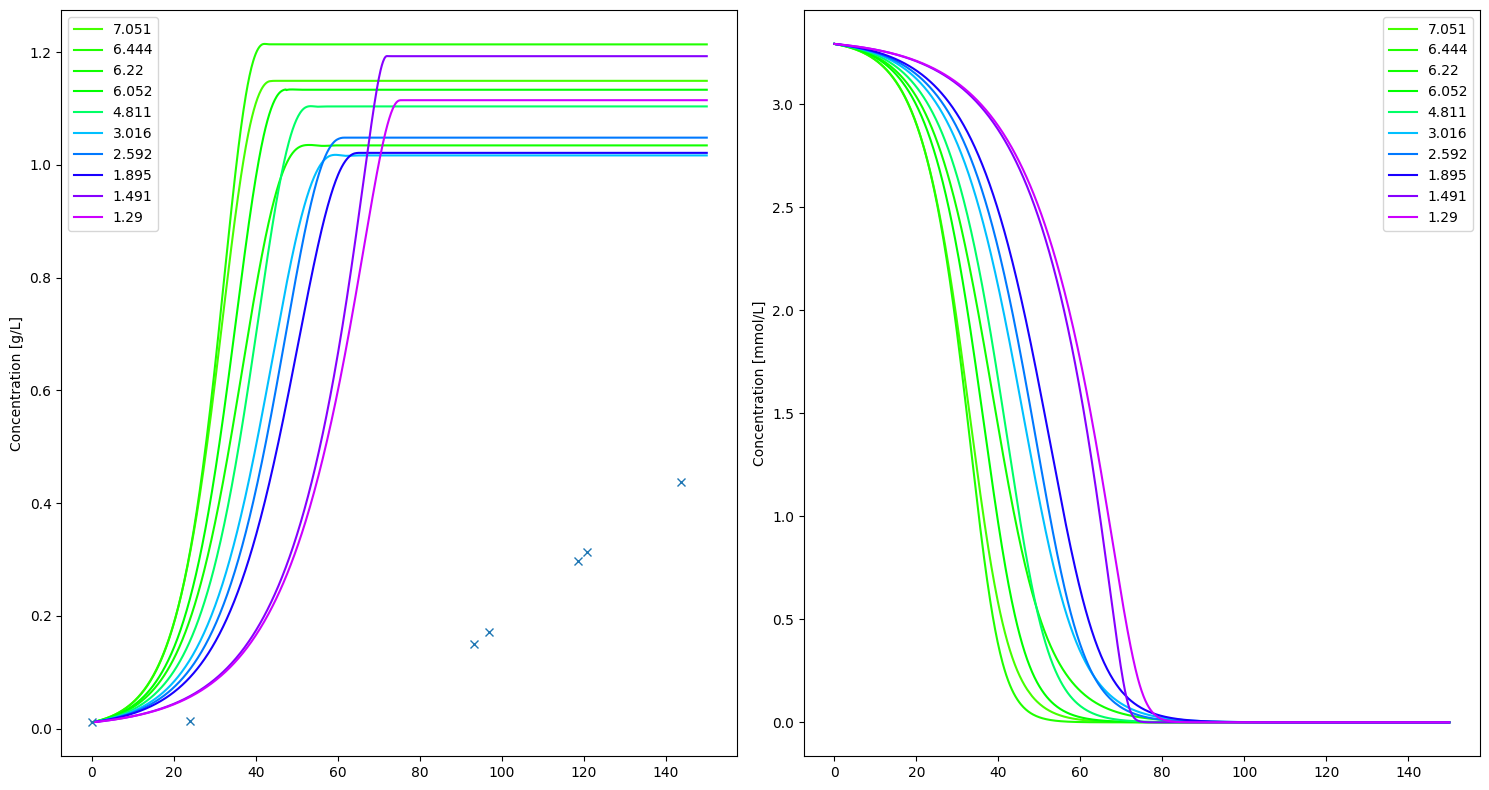

In [72]:
fig,ax = plt.subplots(1,2,figsize=(15,8))

i=0
for key,results in best_results_oligo_dict.items():
    t,C_dict_results = results
    ax[0].plot(t, C_dict_results["Growth"],label =str(list(best_results_dict.keys())[i]),color=cmap(log_norm(list(best_results_dict.keys())[i])))
    i +=1
    
ax[0].legend()
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD_oligo.x,OD_oligo[" y"],'x',color="tab:blue")

i=0
for key,results in best_results_oligo_dict.items():
    t,C_dict_results = results
    ax[1].plot(t, C_dict_results["EX_QQQG_e"],label =str(list(best_results_dict.keys())[i]),color=cmap(log_norm(list(best_results_dict.keys())[i])))
    i +=1
ax[1].legend()
ax[1].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()

## Optimizing parameters for oligosaccharides

In [3]:
OD_oligo = pd.read_csv("../input/Ravachol2016_batch_data/OD_oligosaccharide.csv")

OD_oligo[" y"] = OD_oligo[" y"]*0.5

In [4]:
model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})


C_dict =OrderedDict({
"Growth":OD_oligo.iloc[0,1],
"EX_QQQG_e": 3.5*1000/molarmass,
"EX_xylogluc_e":0})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14


CPU times: user 13.8 s, sys: 3.4 s, total: 17.2 s
Wall time: 17min 29s

#### Polishing solutions

In [5]:
best_evo_min_sorted = pd.read_csv("../output/differential_evolution_results_xyloglucan_oligosaccharides.csv",index_col=0)
best_evo_min_sorted.reset_index(drop=True,inplace=True)
best_evo_min_sorted

,0,1,penalty
0,0.198158,2.885918,0.402613
1,0.185382,2.599529,0.964505
2,0.156520,1.757606,1.479939
3,0.260959,4.647832,1.746316
4,0.353841,7.512438,1.755774
5,0.379302,8.182299,1.898763
6,0.236319,4.154648,2.341172
7,0.409444,8.986721,2.463396
8,0.318655,6.200110,4.747157
9,0.302043,6.197673,4.783531


In [10]:
results.keys()

dict_keys([(0.1853818517052674, 2.5995287802867), (0.3538410433075181, 7.512437875809416), (0.260959350488527, 4.647832000090576), (0.3793024779511339, 8.182298551414803), (0.2363189407414213, 4.154648079422232), (0.4094440869439261, 8.98672057958325), (0.3186547326102724, 6.200109592381901)])

In [6]:
from scipy.optimize import minimize

from concurrent.futures import ProcessPoolExecutor, as_completed

from dfba_param_opt_cobra import optimize_with_powell

In [7]:
model=read_model(media)

In [8]:
# Generate multiple starting points
                      
starting_points = [best_evo_min_sorted.iloc[i,[0,1]].values for i in np.arange(0,10)]


arguments = (model,media,rxns,y0,objective_dir,xylog_glc_eq_dict,OD_oligo)

In [12]:
starting_points

[array([0.19815795, 2.88591801]),
 array([0.18538185, 2.59952878]),
 array([0.15651974, 1.75760551]),
 array([0.26095935, 4.647832  ]),
 array([0.35384104, 7.51243788]),
 array([0.37930248, 8.18229855]),
 array([0.23631894, 4.15464808]),
 array([0.40944409, 8.98672058]),
 array([0.31865473, 6.20010959]),
 array([0.30204344, 6.19767286])]

In [9]:
# Run Powell's method in parallel
results = {}
with ProcessPoolExecutor(max_workers=4) as executor:
    # Submit tasks and keep a map of future -> starting point
    future_to_starting_point = {
        executor.submit(optimize_with_powell, starting_point=sp,arguments=arguments): sp for sp in starting_points
    }

    for future in as_completed(future_to_starting_point):
        starting_point = future_to_starting_point[future]
        try:
            result = future.result()
            results[tuple(starting_point)] = result  # Use tuple(starting_point) as key for immutability
        except Exception as e:
            print(f"Optimization failed for starting point {starting_point}: {e}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Set parameter Username
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpqomhwhka.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpu2a9i6ul.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmp89rvs5xl.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmp5jga5lr2.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


Optimization failed for starting point [0.30204344 6.19767286]: The lower bound must be less than or equal to the upper bound (1461.905732159986 <= 1000.0).

[0.30472708 6.21853649]
penalty: 3.34531270547217
[0.2285381  3.88146351]
penalty: 1.3108596757740034
[0.18145072 2.43707298]
penalty: 0.25842394054217127
[0.15234912 1.54439053]
penalty: 0.975858488124462
[0.18688003 2.6036153 ]
penalty: 0.31628678911067165
[0.17895424 2.36049414]
penalty: 0.2435801945311917
[0.16879199 2.0487703 ]
penalty: 0.28821158655963414
[0.17656208 2.28711536]
penalty: 0.23763790206922736
[0.17600419 2.27000243]
penalty: 0.2375307713803087
[0.17615955 2.27476813]
penalty: 0.2375096537732672
[0.17616529 2.27494401]
penalty: 0.2375096321300545
[0.17616472 2.27492665]
penalty: 0.2375096318740001
[0.17616474 2.27492716]
penalty: 0.23750963187405644
[0.17616471 2.27492614]
penalty: 0.237509631874376
[0.30628078 6.21853649]
penalty: 2.4686148658317753
[0.22917104 3.88146351]
penalty: 0.9938032802460698
[0.181514

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/Users/idunmariaburgos/opt/anaconda3/envs/rcell_rec/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/idunmariaburgos/opt/anaconda3/envs/rcell_rec/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/idunmariaburgos/opt/anaconda3/envs/rcell_rec/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/idunmariaburgos/opt/anaconda3/envs/rcell_rec/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/Users/idunmariaburgos/opt/anaconda3/envs/rcell_rec/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInter

Started optimizing for [0.30204344 6.19767286]
[0.30204344 6.19767286]
penalty: 4.783531186898632
[0.44376941 6.19767286]
penalty: 640.0806650929142
[0.65623059 6.19767286]
penalty: 1606.8600406847222
[0.31246118 6.19767286]
penalty: 1.4963970099399875
[0.23130823 6.19767286]
penalty: 172.8729654755189
[0.30404732 6.19767286]
penalty: 3.3290108881090195
[0.31242785 6.19767286]
penalty: 1.4894095624622465
[0.31038951 6.19767286]
penalty: 1.2725583157822713
[0.30796701 6.19767286]
penalty: 1.5965807714122173
[0.31034123 6.19767286]
penalty: 1.27297225005671
[0.31044319 6.19767286]
penalty: 1.27237936498748
[0.31047652 6.19767286]
penalty: 1.2724174115770501
[0.31044319 3.88146351]
penalty: 535.9348208586495
[0.31044319 6.21853649]
penalty: 1.3050319471040899
[0.31044319 7.66292702]
penalty: 73.37715818373034
[0.31044319 6.60216795]
penalty: 9.783357849980604
[0.31044319 5.98868215]
penalty: 4.035930404439448
[0.31044319 6.21085725]
penalty: 1.2870231381879582
[0.31044319 6.19638446]
pena

KeyboardInterrupt: 

In [10]:
results.keys()

dict_keys([(0.1853818517052674, 2.5995287802867), (0.3538410433075181, 7.512437875809416), (0.260959350488527, 4.647832000090576), (0.3793024779511339, 8.182298551414803), (0.2363189407414213, 4.154648079422232), (0.4094440869439261, 8.98672057958325), (0.3186547326102724, 6.200109592381901)])

In [11]:
results

{(0.1853818517052674,
  2.5995287802867): {'starting_point': array([0.18538185, 2.59952878]), 'solution': array([0.18741173, 2.59909265]), 'objective_value': 0.23347188992252377},
 (0.3538410433075181,
  7.512437875809416): {'starting_point': array([0.35384104, 7.51243788]), 'solution': array([0.18183895, 2.43672521]), 'objective_value': 0.22747637074799887},
 (0.260959350488527,
  4.647832000090576): {'starting_point': array([0.26095935, 4.647832  ]), 'solution': array([0.18183883, 2.43672183]), 'objective_value': 0.22747637074747162},
 (0.3793024779511339,
  8.182298551414803): {'starting_point': array([0.37930248, 8.18229855]), 'solution': array([0.18183822, 2.43670449]), 'objective_value': 0.22747637088193878},
 (0.2363189407414213,
  4.154648079422232): {'starting_point': array([0.23631894, 4.15464808]), 'solution': array([0.18186708, 2.43731575]), 'objective_value': 0.22748849409727476},
 (0.4094440869439261,
  8.98672057958325): {'starting_point': array([0.40944409, 8.98672058])

In [41]:
%%time
polished_solutions = {}

for i in np.arange(0,10):
    guess = best_evo_min_sorted.iloc[i,[0,1]].values
    penalty = best_evo_min_sorted.iloc[i,-1]
    polished_solutions[i]={"diff_ev":{"parameters":guess,"penalty":penalty }}
    
    print(f"Started polishing solutions for {i}, guess: {guess}, penalty: {penalty}")
    
    model = read_model(media)
    result =minimize(optimize_parameters_inner_problem_oligo,
                      guess,
                      method="Powell",
                      bounds=[(0.1,1),(0.1,10)],
                      args=(model,media,rxns,y0,objective_dir,xylog_glc_eq_dict,OD_oligo),
                     options ={'maxiter':100,'xtol': 1e-4,'ftol':1e-4},
                      #parallel = {'max_workers':4,'verbose':False}
                    )
    
    polished_solutions[i]["polished"] = {"parameters":result.x,"penalty":result.fun,"message":result.message}
    

Started polishing solutions for 0, guess: [0.19815795 2.88591801], penalty: 0.4026128323626505
[0.19815795 2.88591801]
penalty: 0.40261283236236844
[0.44376941 2.88591801]
penalty: 2150.962857878692
[0.65623059 2.88591801]
penalty: 3453.4541018685245
[0.31246118 2.88591801]


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


OptimizationError: None (interrupted).

CPU times: user 42.9 s, sys: 2.68 s, total: 45.6 s
Wall time: 16min 13s

#### Plotting results

In [118]:
df_results = pd.read_csv("../output/polished_results_diff_ev_oligosaccharides.tsv",sep="\t",header=[0,1],index_col=0)
df_results.sort_values(("polished","penalty"))

origin diff_ev                                     \
data   message               parameters   penalty   
5          NaN  [0.37930248 8.18229855]  1.898763   
3          NaN  [0.26095935 4.647832  ]  1.746316   
8          NaN  [0.31865473 6.20010959]  4.747157   
1          NaN  [0.18538185 2.59952878]  0.964505   
0          NaN  [0.19815795 2.88591801]  0.402613   
2          NaN  [0.15651974 1.75760551]  1.479939   
6          NaN  [0.23631894 4.15464808]  2.341172   
9          NaN  [0.30204344 6.19767286]  4.783531   
4          NaN  [0.35384104 7.51243788]  1.755774   
7          NaN  [0.40944409 8.98672058]  2.463396   

origin                                         polished  \
data                                            message   
5       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
3       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
8       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
1       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
0       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
2       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
6       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
9       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
4       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
7       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

origin                                     
data                 parameters   penalty  
5       [0.18183559 2.43662732]  0.227476  
3       [0.18183524 2.4366176 ]  0.227476  
8       [0.18179992 2.43553882]  0.227477  
1       [0.18722765 2.59386119]  0.233099  
0       [0.1978882  2.90465501]  0.271508  
2       [0.15838775 1.75394246]  0.382455  
6       [0.23998302 4.13510688]  0.604911  
9       [0.30852435 6.14068804]  1.254994  
4       [0.35505177 7.50512996]  1.677030  
7       [0.40595935 8.99808878]  2.046310

In [108]:
polished_df = df_results.xs("polished",axis=1)[["parameters","penalty"]].sort_values("penalty",ascending=False).copy()

In [109]:
best_results_oligo_dict = OrderedDict()

for i,row in polished_df.iterrows():
    print(i)
    s = row["parameters"]
    s = s.strip("[]")
    combination = list(map(float,s.split()))
    model = read_model(media)

    model = read_model(media)
    sol,penalty = optimize_parameters_inner_problem_oligo(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,xylog_glc_eq_dict=xylog_glc_eq_dict,OD=OD_oligo,alternative_solution=True)
    
    C_dict_results = dict(zip(C_dict.keys(),sol.y))
    
    best_results_oligo_dict[round(penalty,3)]=(sol.t,C_dict_results)
    

7
[0.40595935, 8.99808878]
penalty: 2.0463101809526565
4
[0.35505177, 7.50512996]
penalty: 1.677030213697464
9
[0.30852435, 6.14068804]
penalty: 1.2549937139540603
6
[0.23998302, 4.13510688]
penalty: 0.6049110399032253
2
[0.15838775, 1.75394246]
penalty: 0.3824553277359631
0
[0.1978882, 2.90465501]
penalty: 0.2715075844785923
1
[0.18722765, 2.59386119]
penalty: 0.2330993151634783
8
[0.18179992, 2.43553882]
penalty: 0.2274772529339281
3
[0.18183524, 2.4366176]
penalty: 0.22747637359554554
5
[0.18183559, 2.43662732]
penalty: 0.2274763730768744


In [116]:
# Generate some example values between 1 and 120, with many values clustered near 10
values = list(best_results_oligo_dict.keys())

# Use LogNorm to normalize values logarithmically
log_norm = mcolors.LogNorm(vmin=0.1, vmax=5)

# Choose a colormap, e.g., viridis
cmap = plt.cm.gist_rainbow_r

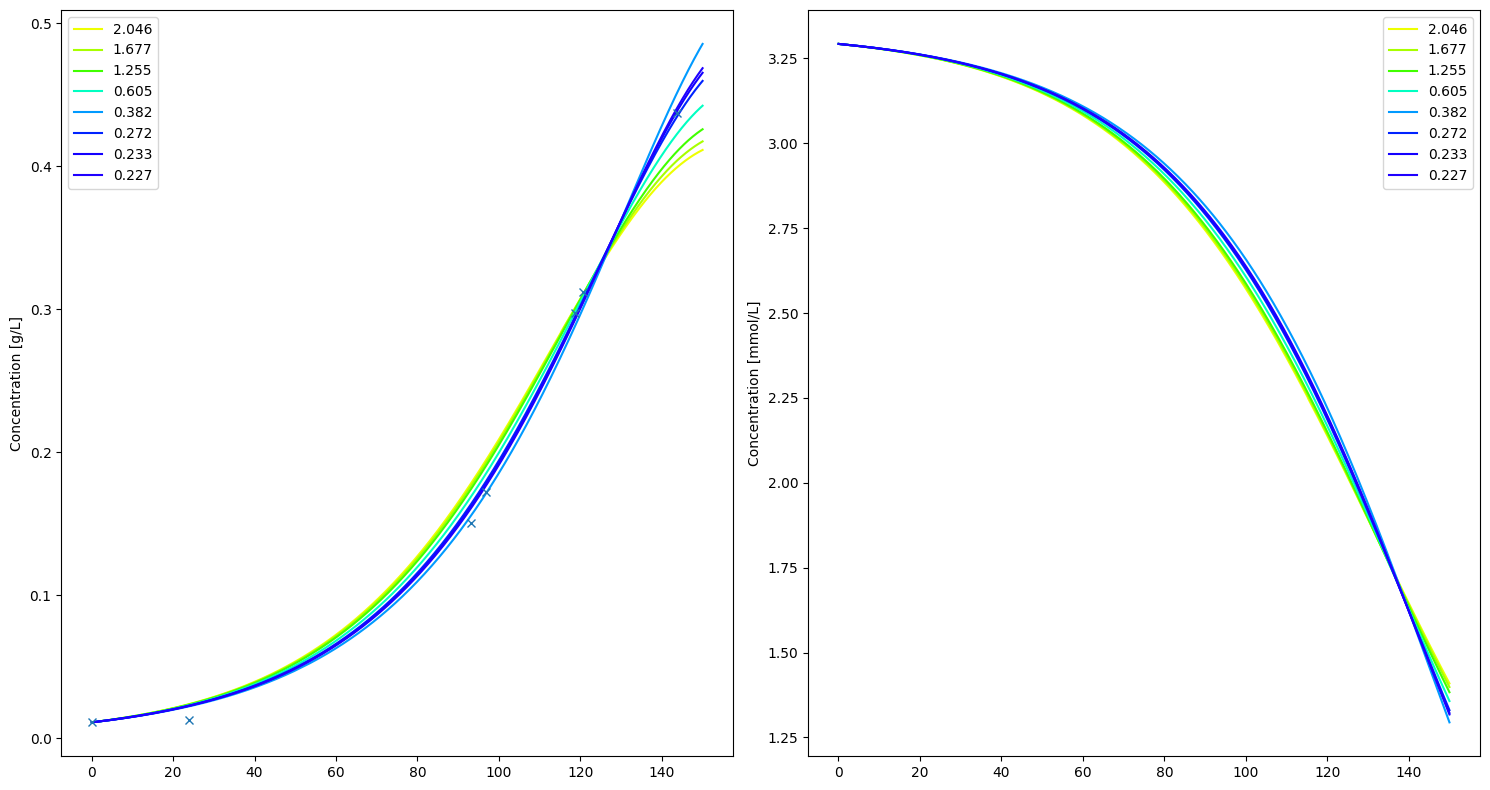

In [117]:
fig,ax = plt.subplots(1,2,figsize=(15,8))

i=0
for key,results in best_results_oligo_dict.items():
    t,C_dict_results = results
    ax[0].plot(t, C_dict_results["Growth"],label =str(list(best_results_oligo_dict.keys())[i]),color=cmap(log_norm(list(best_results_oligo_dict.keys())[i])))
    i +=1
    
ax[0].legend()
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD_oligo.x,OD_oligo[" y"],'x',color="tab:blue")

i=0
for key,results in best_results_oligo_dict.items():
    t,C_dict_results = results
    ax[1].plot(t, C_dict_results["EX_QQQG_e"],label =str(list(best_results_oligo_dict.keys())[i]),color=cmap(log_norm(list(best_results_oligo_dict.keys())[i])))
    i +=1
ax[1].legend()
ax[1].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()

### From xyloglucan fitting with parameters from oligosaccharides

#### Vmax and Km from oligosaccharides

In [9]:
OD = pd.read_csv("../input/Ravachol2016_batch_data/OD_xyloglucan.csv")
OD[" y"] = OD[" y"]*0.5

model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})

C_dict =OrderedDict({
"Growth":OD.iloc[0,1],
"EX_QQQG_e": 0,
"EX_xylogluc_e": 3.5*1000/(molarmass/xylog_glc_eq_dict["EX_QQQG_e"])
})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


##### Differential evolution

In [10]:
best_evo_min_sorted = pd.read_csv("../output/differential_evolution_results_xyloglucan_3_parameters.csv",index_col=0)
best_evo_min_sorted

,0,1,2,penalty,r2 approx
0,19.960141,0.247848,19.433690,1569.128088,-0.569128
1,19.726683,0.173305,18.702349,1572.396651,-0.572397
2,19.586005,0.162981,18.155657,1576.138006,-0.576138
3,19.379673,0.243991,19.425211,1586.638180,-0.586638
4,19.627281,0.573999,19.659126,1591.531536,-0.591532
5,19.454792,0.506347,18.572512,1597.577074,-0.597577
6,19.391992,0.503092,19.188036,1599.342293,-0.599342
7,19.655998,0.738564,19.684352,1601.445793,-0.601446
8,19.753550,0.939135,17.625063,1609.613324,-0.609613


In [12]:
combination = best_evo_min_sorted.iloc[0,[0,1,2]].values
model = read_model(media)

In [14]:
model = read_model(media)
sol,penalty = optimize_parameters_inner_problem_simplified([19.96014099  0.24784818 19.43369029],model,media,rxns,y0,objective_dir,xylog_glc_eq_dict,OD,alternative_solution=True,simplified=1)


[19.96014099  0.24784818 19.43369029]
1-r2: 1569.1280743876428 and r2: -0.5689709740368791


In [15]:
C_dict_results = dict(zip(rxns,sol.y))

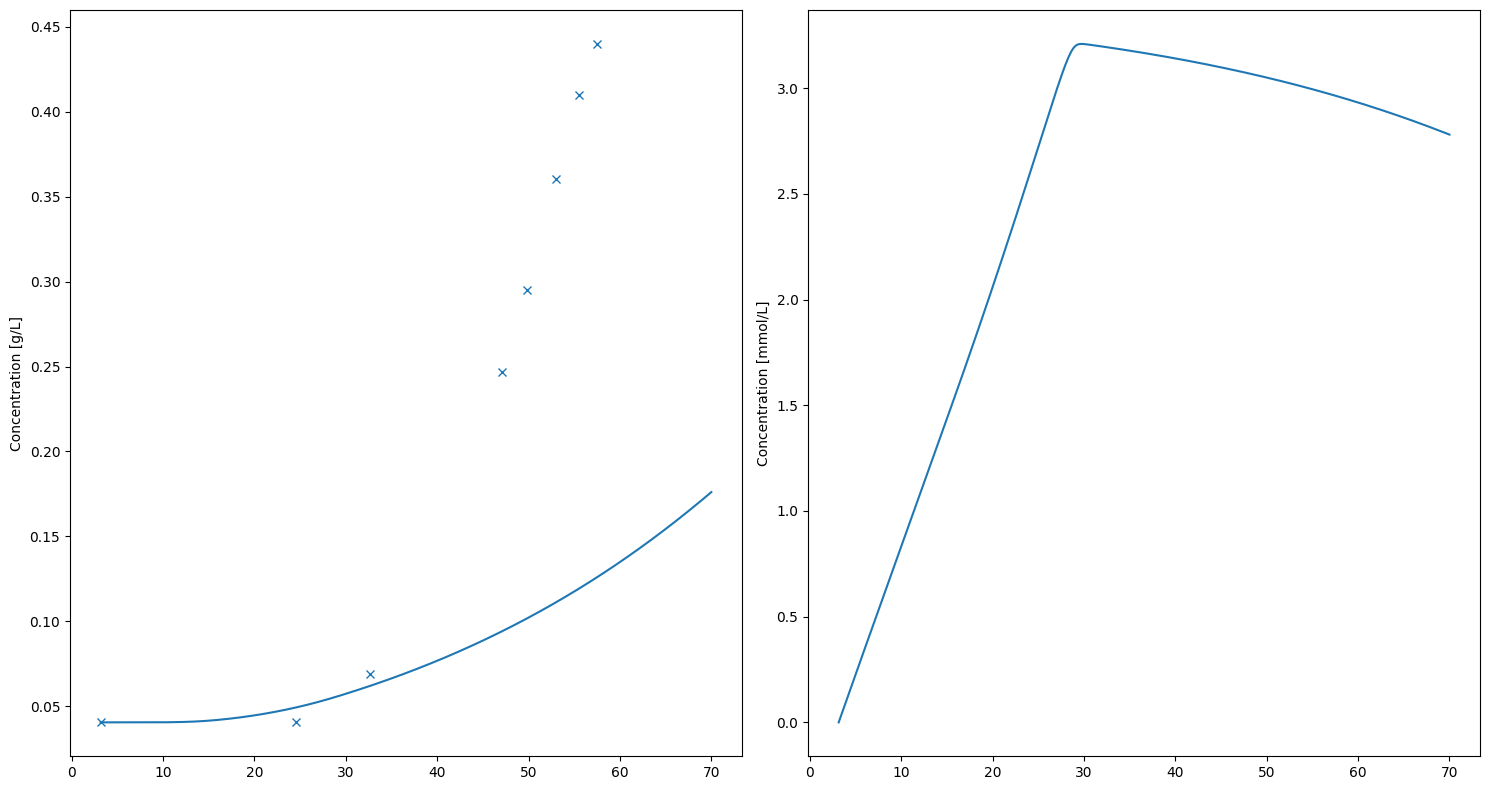

In [16]:
fig,ax = plt.subplots(1,2,figsize=(15,8))


ax[0].plot(sol.t, C_dict_results["Growth"])
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD.x,OD[" y"],'x',color="tab:blue")

i=0

ax[1].plot(sol.t, C_dict_results["EX_QQQG_e"])
ax[1].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()

### Only vmax from oligosaccharides

In [6]:
OD = pd.read_csv("../input/Ravachol2016_batch_data/OD_xyloglucan.csv")
OD[" y"] = OD[" y"]*0.5

model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})

C_dict =OrderedDict({
"Growth":OD.iloc[0,1],
"EX_QQQG_e": 0,
"EX_xylogluc_e": 3.5*1000/(molarmass/xylog_glc_eq_dict["EX_QQQG_e"])
})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


##### Differential evolution

CPU times: user 28.7 s, sys: 6.97 s, total: 35.7 s
Wall time: 45min 45s

In [19]:
energies_min = np.array(energies_min)

pop_up_min = [pop_min[0]]
energies_up_min = [energies_min[0]]
for i in range(1, len(pop_min)):
    new_energies_min = np.copy(energies_up_min[-1])
    new_pop_min = np.copy(pop_up_min[-1])
    pos_min = energies_min[i] < new_energies_min
    new_energies_min[pos_min] = energies_min[i][pos_min]
    new_pop_min[pos_min] = pop_min[i][pos_min]
    pop_up_min.append(new_pop_min)
    energies_up_min.append(new_energies_min)

best_evo_min = pd.DataFrame(pop_up_min[-1])

best_evo_min["penalty"]=energies_up_min[-1]

best_evo_min_sorted = best_evo_min.sort_values("penalty")

best_evo_min_sorted.reset_index(drop=True).to_csv("../output/differential_evolution_results_xyloglucan_4_parameters.csv")
best_evo_min_sorted

,0,1,2,3,penalty
19,0.364642,7.858748,1.576274,6.035183,1.395863
10,0.337961,8.208814,3.801805,8.573855,1.411172
11,0.400434,8.699691,0.980093,1.347150,1.419540
7,0.325551,7.775535,2.798270,2.410466,1.448963
5,0.364556,8.026457,2.130529,8.231404,1.454566
9,0.269272,6.663207,4.521443,9.400846,1.458601
13,0.370144,7.335589,0.468378,9.011941,1.472567
14,0.377655,9.702681,4.144943,4.834953,1.478105
12,0.320967,8.877727,6.305602,9.844905,1.481345
2,0.423649,9.448943,1.978203,7.259335,1.510956


##### Polishing results CONTINUE HERE

In [5]:
best_evo_min_sorted = pd.read_csv("../output/differential_evolution_results_xyloglucan_4_parameters.csv",index_col=0)
best_evo_min_sorted

,0,1,2,3,penalty
0,0.364642,7.858748,1.576274,6.035183,1.395863
1,0.337961,8.208814,3.801805,8.573855,1.411172
2,0.400434,8.699691,0.980093,1.347150,1.419540
3,0.325551,7.775535,2.798270,2.410466,1.448963
4,0.364556,8.026457,2.130529,8.231404,1.454566
5,0.269272,6.663207,4.521443,9.400846,1.458601
6,0.370144,7.335589,0.468378,9.011941,1.472567
7,0.377655,9.702681,4.144943,4.834953,1.478105
8,0.320967,8.877727,6.305602,9.844905,1.481345
9,0.423649,9.448943,1.978203,7.259335,1.510956


In [7]:
%%time

polished_solutions = {}

for i in np.arange(0,10):
    
    guess = best_evo_min_sorted.iloc[i,[0,1,2,3]].values
    penalty = best_evo_min_sorted.iloc[i,-1]
    polished_solutions[i]={"diff_ev":{"parameters":guess,"penalty": penalty}}
    
    print(f"Started polishing solutions for {i}, guess: {guess}, penalty: {penalty}")
    
    model = read_model(media)
    result = minimize_parallel(optimize_parameters_inner_problem_simplified,
                      guess,
                      bounds=[(0.1,10),(0.1,10),(0.1,10),(0.1,10)],
                      args=(model,media,rxns,y0,objective_dir,xylog_glc_eq_dict,OD,False,2),
                     options ={'maxiter':100,'gtol': 1e-3,'ftol':1e-4},
                      parallel = {'max_workers':4,'verbose':False})
    
    polished_solutions[i]["polished"] = {"parameters":result.x,"penalty": result.fun,"message":result.message}
    

Started polishing solutions for 0, guess: [0.36464151 7.858748   1.57627373 6.03518271], penalty: 1.3958625645163996
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
Academic license - for non-commercial use only - expires 2025-03-14
Academic license - for non-commercial use only - expires 2025-03-14
Academic license - for non-commercial use only - expires 2025-03-14
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmphm47eyj1.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmptsdxso8r.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Read LP format model from file /var/folders/mc/1rm74nkd4s78l46281nyt5wm0000gn/T/tmpfoflgrgm.lp
Reading time = 0.01 seconds
: 1065 rows, 5244 columns, 15970 nonzeros
Read LP format model fro

In [9]:
df = pd.DataFrame.from_dict({(i,j): polished_solutions[i][j] 
                           for i in polished_solutions.keys() 
                           for j in polished_solutions[i].keys()},
                       orient='index').unstack()


df.T.index.names = ["data","origin"]

df_results = df.T.reorder_levels(["origin","data"]).sort_index().T
df_results

origin diff_ev                                                               \
data   message                                         parameters   penalty   
0          NaN  [0.3646415138442433, 7.858748001819778, 1.5762...  1.395863   
1          NaN  [0.337960617219065, 8.208814044399954, 3.80180...  1.411172   
2          NaN  [0.4004337233572084, 8.69969089549022, 0.98009...   1.41954   
3          NaN  [0.3255510707563402, 7.775534996776443, 2.7982...  1.448963   
4          NaN  [0.3645556175544353, 8.026456555715551, 2.1305...  1.454566   
5          NaN  [0.2692724191020952, 6.663206721849344, 4.5214...  1.458601   
6          NaN  [0.3701435128229411, 7.335588740716657, 0.4683...  1.472567   
7          NaN  [0.3776553535747577, 9.702681437415263, 4.1449...  1.478105   
8          NaN  [0.3209668757931245, 8.877726918815885, 6.3056...  1.481345   
9          NaN  [0.4236488359459418, 9.448943065543396, 1.9782...  1.510956   

origin                                         polished  \
data                                            message   
0       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
1       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
2       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
3       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
4       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
5       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
6       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
7       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
8       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
9       CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

origin                                                               
data                                           parameters   penalty  
0       [0.3610371826303217, 7.861813805293301, 1.5722...  1.369978  
1       [0.3368642232330996, 8.209572340065565, 3.8012...  1.408329  
2       [0.4001557778991508, 8.69974157654275, 0.98006...  1.419415  
3       [0.3286133478997049, 7.775382098718612, 2.7983...  1.426838  
4       [0.35888560429141314, 8.034924878538723, 2.109...  1.378628  
5       [0.2670605376702114, 6.673622769984027, 4.5181...  1.434084  
6       [0.36337082931036685, 7.375118246971565, 0.459...  1.336206  
7       [0.3812349482368773, 9.702459081819374, 4.1450...  1.455845  
8       [0.325042150240709, 8.877444260311137, 6.30569...  1.441168  
9       [0.41671585921640325, 9.460759804805692, 1.957...  1.429988

In [11]:
df_results.sort_values(("polished","penalty"),ascending=False).to_csv("../output/polished_results_diff_ev_4_parameters.tsv",sep="\t")

In [12]:
df_results = pd.read_csv("../output/polished_results_diff_ev_4_parameters.tsv",sep="\t",header=[0,1])

In [13]:
df_results

origin diff_ev                                                           \
    data message                                     parameters   penalty   
0      7     NaN  [0.37765535 9.70268144 4.14494319 4.83495326]  1.478105   
1      8     NaN  [0.32096688 8.87772692 6.30560223 9.84490484]  1.481345   
2      5     NaN  [0.26927242 6.66320672 4.52144278 9.40084575]  1.458601   
3      9     NaN  [0.42364884 9.44894307 1.97820265 7.25933469]  1.510956   
4      3     NaN  [0.32555107 7.775535   2.79827026 2.41046565]  1.448963   
5      2     NaN  [0.40043372 8.6996909  0.98009293 1.34714999]  1.419540   
6      1     NaN  [0.33796062 8.20881404 3.80180456 8.57385534]  1.411172   
7      4     NaN  [0.36455562 8.02645656 2.13052891 8.23140388]  1.454566   
8      0     NaN  [0.36464151 7.858748   1.57627373 6.03518271]  1.395863   
9      6     NaN  [0.37014351 7.33558874 0.46837767 9.0119408 ]  1.472567   

                                          polished  \
                                           message   
0  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
1  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
2  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
3  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
4  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
5  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
6  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
7  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
8  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   
9  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

                                                            
                                      parameters   penalty  
0  [0.38123495 9.70245908 4.14500303 4.83493453]  1.455845  
1  [0.32504215 8.87744426 6.30569888 9.84485302]  1.441168  
2  [0.26706054 6.67362277 4.51814351 9.40018158]  1.434084  
3  [0.41671586 9.4607598  1.95737707 7.24819869]  1.429988  
4  [0.32861335 7.7753821  2.79830656 2.41050575]  1.426838  
5  [0.40015578 8.69974158 0.98006953 1.34719474]  1.419415  
6  [0.33686422 8.20957234 3.80126247 8.57386986]  1.408329  
7  [0.3588856  8.03492488 2.10914431 8.21996865]  1.378628  
8  [0.36103718 7.86181381 1.57224812 6.03531208]  1.369978  
9  [0.36337083 7.37511825 0.45925326 9.00965743]  1.336206

In [14]:
polished_df = df_results.xs("polished",axis=1)

In [15]:
best_results_dict = OrderedDict()

for i,row in polished_df.iterrows():
    print(i)
    s = row["parameters"]
    s = s.strip("[]")
    combination = list(map(float,s.split()))
    model = read_model(media)
    sol,penalty = optimize_parameters_inner_problem_simplified(combination=combination,model=model,media=media,rxns=rxns,y0=y0,objective_dir=objective_dir,xylog_glc_eq_dict=xylog_glc_eq_dict,OD=OD,alternative_solution=True,simplified=2)
    
    C_dict_results = dict(zip(C_dict.keys(),sol.y))
    
    best_results_dict[round(penalty,3)]=(sol.t,C_dict_results)
    

0
[0.38123495, 9.70245908, 4.14500303, 4.83493453]
penalty: 1.4561476496746537
1
[0.32504215, 8.87744426, 6.30569888, 9.84485302]
penalty: 1.441237148902779
2
[0.26706054, 6.67362277, 4.51814351, 9.40018158]
penalty: 1.4340840730532565
3
[0.41671586, 9.4607598, 1.95737707, 7.24819869]
penalty: 1.4303484513039095
4
[0.32861335, 7.7753821, 2.79830656, 2.41050575]
penalty: 1.426907584643983
5
[0.40015578, 8.69974158, 0.98006953, 1.34719474]
penalty: 1.4197650803362165
6
[0.33686422, 8.20957234, 3.80126247, 8.57386986]
penalty: 1.4084252601306109
7
[0.3588856, 8.03492488, 2.10914431, 8.21996865]
penalty: 1.3787586343438194
8
[0.36103718, 7.86181381, 1.57224812, 6.03531208]
penalty: 1.369983152512782
9
[0.36337083, 7.37511825, 0.45925326, 9.00965743]
penalty: 1.336319048682192


In [16]:
best_results_dict.keys()

odict_keys([1.456, 1.441, 1.434, 1.43, 1.427, 1.42, 1.408, 1.379, 1.37, 1.336])

In [26]:
# Use LogNorm to normalize values logarithmically
log_norm = mcolors.LogNorm(vmin=1, vmax=2)

# Choose a colormap, e.g., viridis
cmap = plt.cm.gist_rainbow_r
#cmap(log_norm(best_results_dict.keys()))

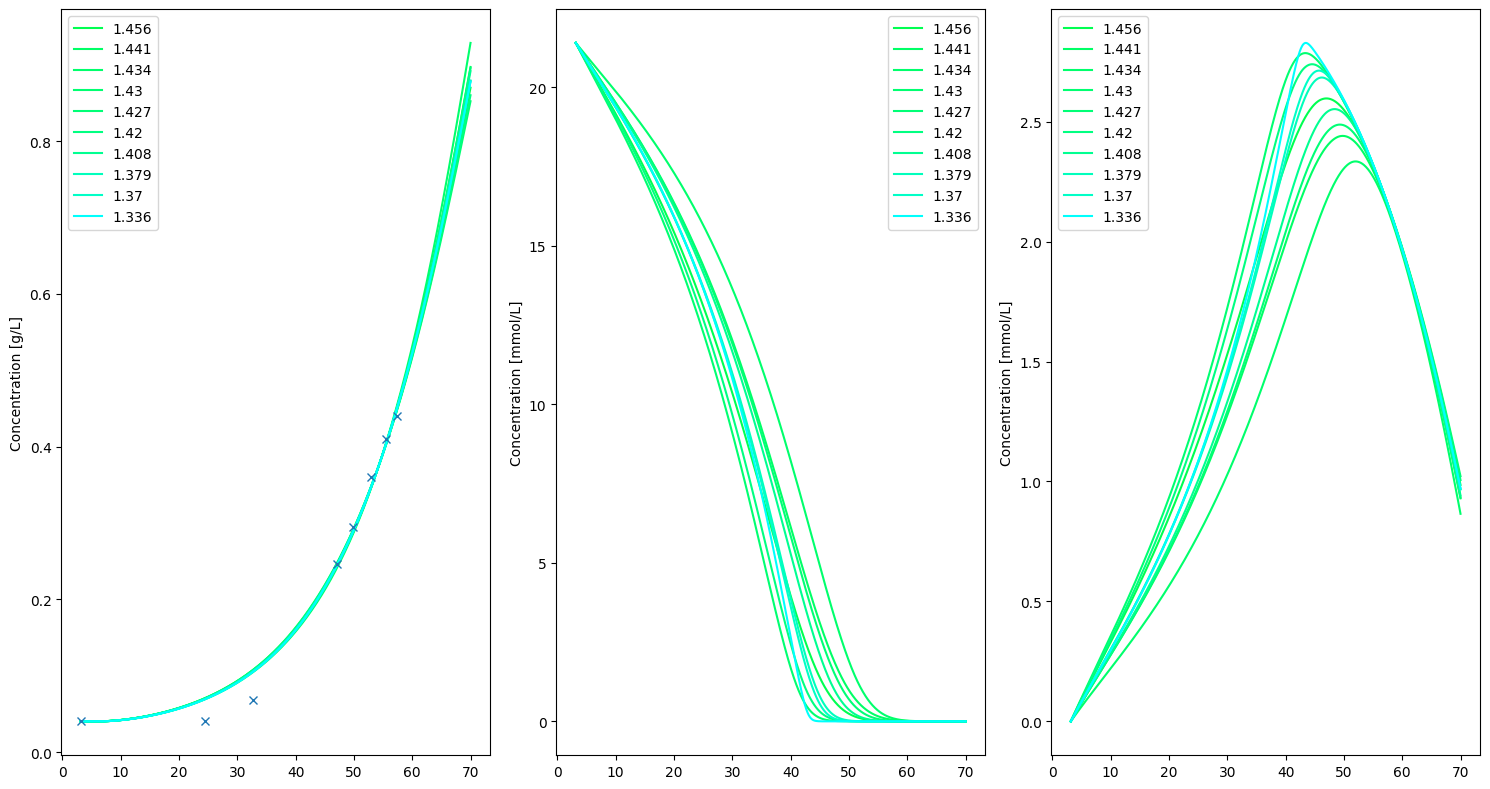

In [27]:
fig,ax = plt.subplots(1,3,figsize=(15,8))


for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[0].plot(t, C_dict_results["Growth"],label =str(key),color=cmap(log_norm(key)))

ax[0].legend()
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD.x,OD[" y"],'x',color="tab:blue")

for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[1].plot(t, C_dict_results["EX_xylogluc_e"], label =str(key),color=cmap(log_norm(key)))
ax[1].legend()
ax[1].set_ylabel('Concentration [mmol/L]')

colors = ['r','g','y','b','pink']
for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[2].plot(t, C_dict_results["EX_QQQG_e"], label =str(key),color=cmap(log_norm(key)))
ax[2].legend()
ax[2].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()

#### Only vmax from oligosaccharides and without Ki

In [63]:
OD = pd.read_csv("../input/Ravachol2016_batch_data/OD_xyloglucan.csv")
OD[" y"] = OD[" y"]*0.5

model = cobra.io.read_sbml_model('../models/RcH10_final.xml')
formula = model.metabolites.get_by_id("QQQG_e").notes["FORMULA"]
molarmass = molmass.Formula(formula).mass

xylog_glc_eq_dict =OrderedDict({
"EX_QQQG_e": 39/6})

C_dict =OrderedDict({
"Growth":OD.iloc[0,1],
"EX_QQQG_e": 0,
"EX_xylogluc_e": 3.5*1000/(molarmass/xylog_glc_eq_dict["EX_QQQG_e"])
})

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max"]
best_r2 = {}

media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()


##### Differential evolution

In [ ]:
%%time
model = read_model(media)

pop_min = []
energies_min = []
res_min = differential_evolution(optimize_parameters_inner_problem_simplified,
                  bounds=[(0.1,10),(0.1,10),(0.1,10)],
                  args=(model,media,rxns,y0,objective_dir,xylog_glc_eq_dict,OD,3),
                  strategy = "rand2bin",
                  workers=maplike_fun,
                  mutation = (0.1,0.5),
                  recombination=0.1,
                  popsize=3,
                  maxiter=50,
                  polish=False,
                  seed=1,
                  updating='deferred')

##### Polishing results

In [27]:
df_results = pd.read_csv("../output/polished_results_diff_ev_4_parameters.tsv",sep="\t",header=[0,1])

In [29]:
polished_df = df_results.xs("polished",axis=1)

In [225]:
best_results_dict.keys()

odict_keys([12.862, 13.347, 13.388, 13.719, 13.782, 13.78, 13.798, 13.859, 13.872, 13.877, 13.993])

In [226]:
# Use LogNorm to normalize values logarithmically
log_norm = mcolors.LogNorm(vmin=12, vmax=14)

# Choose a colormap, e.g., viridis
cmap = plt.cm.gist_rainbow_r
cmap(log_norm(values[0]))

(1.0, 0.0, 0.75, 1.0)

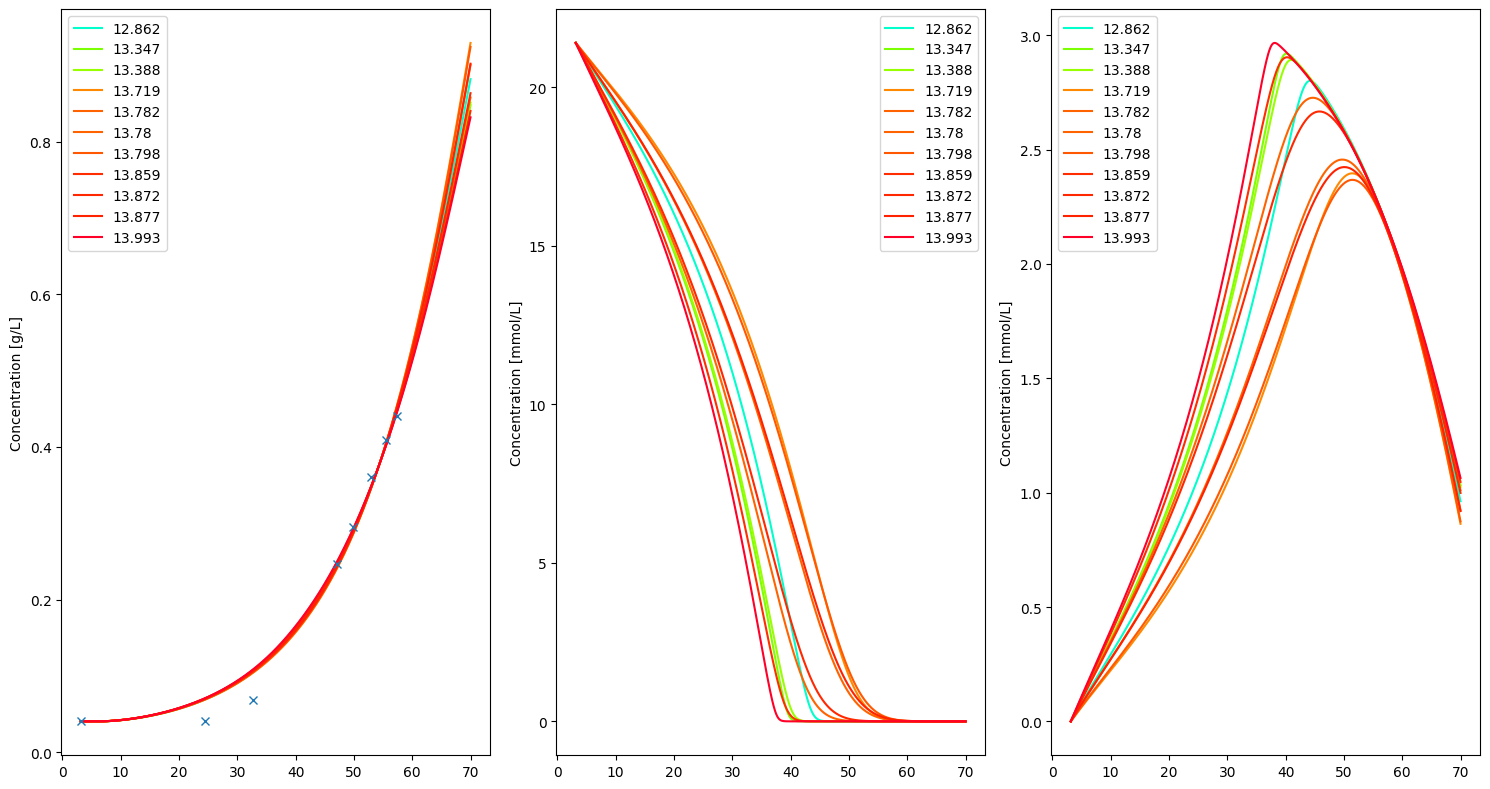

In [227]:
fig,ax = plt.subplots(1,3,figsize=(15,8))


for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[0].plot(t, C_dict_results["Growth"],label =str(key),color=cmap(log_norm(key)))

ax[0].legend()
ax[0].set_ylabel('Concentration [g/L]')
ax[0].plot(OD.x,OD[" y"],'x',color="tab:blue")

for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[1].plot(t, C_dict_results["EX_xylogluc_e"], label =str(key),color=cmap(log_norm(key)))
ax[1].legend()
ax[1].set_ylabel('Concentration [mmol/L]')

colors = ['r','g','y','b','pink']
for key,results in best_results_dict.items():
    t,C_dict_results = results
    ax[2].plot(t, C_dict_results["EX_QQQG_e"], label =str(key),color=cmap(log_norm(key)))
ax[2].legend()
ax[2].set_ylabel('Concentration [mmol/L]')
plt.tight_layout()